In [11]:
from PIL import Image
import numpy as np
import torch
from torch import Tensor
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import requests
import matplotlib.pyplot as plt

%matplotlib inline

LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'

labels = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
   transforms.Resize(255),
   transforms.CenterCrop(224),
   transforms.ToTensor()#,
  # normalize
])
resnet = models.resnet152(pretrained=True)
resnet.training = False
resnet.transform_input = False
resnet.eval()

img_pil = Image.open("West-Highland-White-Terrier-750x410.jpg")
img_tensor = preprocess(img_pil)
img_tensor.unsqueeze_(0) # change the shape from 3x244x244 to 1x3x244x244
img_variable = Tensor(img_tensor)

fc_out = resnet(img_variable)
print("prediction:", labels[fc_out.data.numpy().argmax()])

prediction: West Highland white terrier


In [12]:
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'

labels = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

In [13]:
import pickle
with open("ImageNet_label_dict.pb","wb") as f:
    pickle.dump(labels,f, protocol=pickle.HIGHEST_PROTOCOL)
with open("ImageNet_label_dict.pb","rb") as f:
    b=pickle.load(f)

In [14]:
fake_label = torch.zeros([1,1000]).cuda()
fake_label[0,132] = 1.0

In [24]:
img_variable_cuda = img_variable.cuda()
img_variable_cuda.requires_grad = True
resnet = resnet.cuda()

In [16]:
criterion = nn.MSELoss()
#criterion = F.cross_entropy
optimizer = optim.SGD([img_variable_cuda], lr=0.1, momentum=0.9)

In [27]:
for i in range(100):
    #optimizer.zero_grad()
    fc_out = resnet(img_variable_cuda)
    loss = criterion(fc_out, fake_label)
    loss.backward()

    img_variable_cuda.data = -0.02/100*torch.sign(img_variable_cuda.grad.data)+img_variable_cuda.data

#     img_variable_cuda.grad.zero_()


In [28]:
fc_out = resnet(img_variable_cuda)
print("prediction:", labels[fc_out.cpu().data.numpy().argmax()])

prediction: Arctic fox, white fox, Alopex lagopus


In [34]:
for key in labels.keys():
    if labels[key] == "cockroach, roach":
        print(key, labels[key])

314 cockroach, roach


In [29]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


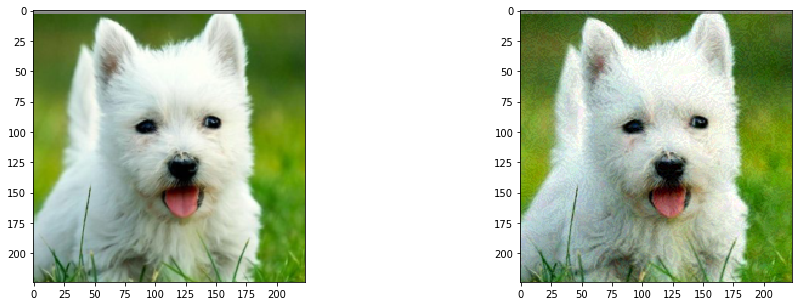

In [30]:

plt.figure(figsize=(16,5))
plt.subplot(121)
orr_img0 = img_tensor[0].transpose(0,2).transpose(0,1).cpu().detach().numpy()
orr_img = inv_normalize(Tensor(orr_img0)).numpy()
plt.imshow(orr_img)

out_img=img_variable_cuda[0].transpose(0,2).transpose(0,1).cpu().detach().numpy()
plt.subplot(122)
plt.imshow(out_img)

# plt.subplot(133)
# plt.imshow(orr_img0)
# plt.show()

In [22]:
out_img.shape

(224, 224, 3)

In [23]:
orr_img0.shape

(224, 224, 3)

In [24]:
def showHist(img, num_bins=20):
    import sys
    if "matplotlib.py" not in sys.modules:
        import matplotlib.pyplot as plt 
    plt.figure(figsize=(16,5))
    for i in range(0,3):
        plt.subplot(131+i)
        plt.hist(img[:,:,i].flatten(),bins=num_bins)
    plt.show()

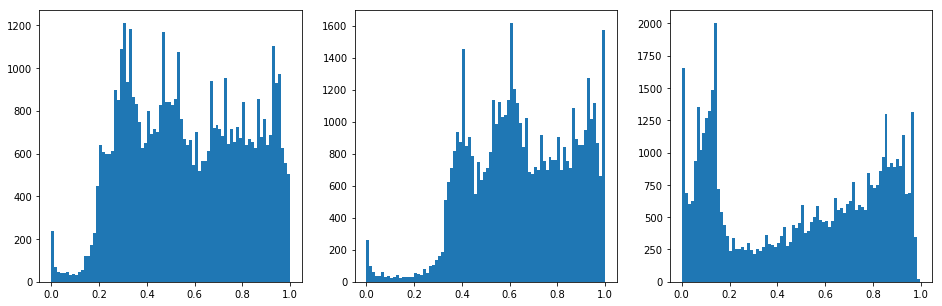

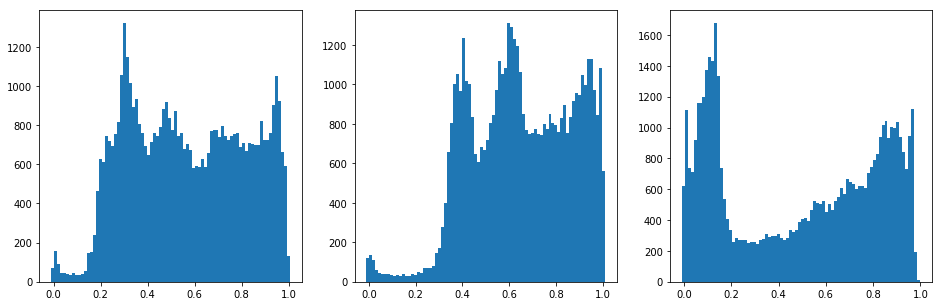

In [25]:
showHist(orr_img0, 80)
showHist(out_img, 80)

In [500]:
def showImageChannel(img):
    plt.figure(figsize=(16,5))
    for i in range(0,3):
        plt.subplot(13*10+i+1)
        plt.imshow(img[:,:,i],cmap='gray')

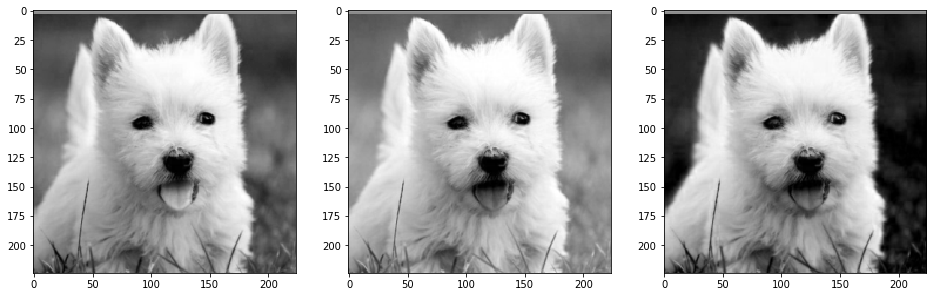

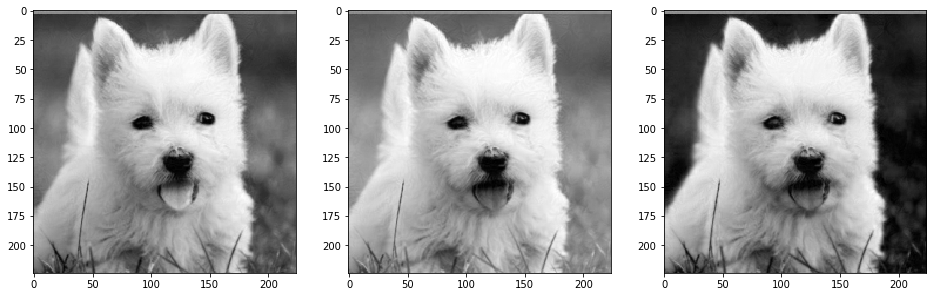

In [507]:
showImageChannel(orr_img0)
showImageChannel(out_img)

In [467]:
img_variable_cuda.shape

torch.Size([1, 3, 224, 224])

In [321]:
class Attack:
    def __init__(self, model, tol, num_steps, step_size, random_start):
        self.model = model
        self.tol = tol
        self.num_steps = num_steps
        self.step_size = step_size
        self.rand = random_start

        self.xs = tf.Variable(np.zeros((1, 32, 32, 3), dtype=np.float32),
                                    name='modifier')
        self.orig_xs = tf.placeholder(tf.float32, [None, 32, 32, 3])

        self.ys = tf.placeholder(tf.int32, [None])

        self.epsilon = 8

        delta = tf.clip_by_value(self.xs, 0, 255) - self.orig_xs
        delta = tf.clip_by_value(delta, -self.epsilon, self.epsilon)

        self.do_clip_xs = tf.assign(self.xs, self.orig_xs+delta)

        self.logits = logits = model(self.xs)

        label_mask = tf.one_hot(self.ys, 10)
        correct_logit = tf.reduce_sum(label_mask * logits, axis=1)
        wrong_logit = tf.reduce_max((1-label_mask) * logits - 1e4*label_mask, axis=1)

        self.loss = (correct_logit - wrong_logit)

        start_vars = set(x.name for x in tf.global_variables())
        optimizer = tf.train.AdamOptimizer(step_size*1)

        grad,var = optimizer.compute_gradients(self.loss, [self.xs])[0]
        self.train = optimizer.apply_gradients([(tf.sign(grad),var)])

        end_vars = tf.global_variables()
        self.new_vars = [x for x in end_vars if x.name not in start_vars]

    def perturb(self, x, y, sess):
        sess.run(tf.variables_initializer(self.new_vars))
        sess.run(self.xs.initializer)
        sess.run(self.do_clip_xs,
                 {self.orig_xs: x})

        for i in range(self.num_steps):

            sess.run(self.train, feed_dict={self.ys: y})
            sess.run(self.do_clip_xs,
                     {self.orig_xs: x})

        return sess.run(self.xs)

In [399]:
fake_label = torch.zeros([1,1000]).cuda(1)

RuntimeError: CUDA error (10): invalid device ordinal